In [16]:
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [17]:
# Data paths
train_path = r'E:\projectdeep\traindata'
test_path = r'E:\projectdeep\testdata'

# Image size
img_size = 256
# Batch size
batch_size = 32

#  augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest'
)

Found 104 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


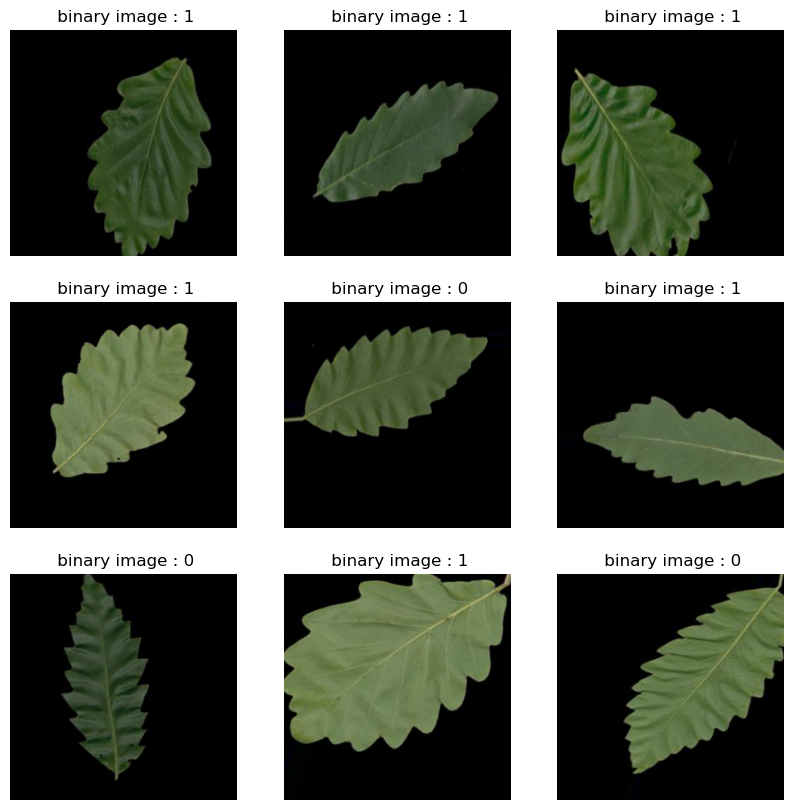

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)
# Display some sample images
sample_images, sample_labels = train_generator.next()
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f" binary image : {int(sample_labels[i])}") 
    plt.axis('off')
plt.show()


In [27]:
# VGG model
vgg = VGG16(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

# Add layers
x = Flatten()(vgg.output)
x = Dropout(0.2)(x)
#  the number of neurons in the fully connected layers
prediction = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
prediction = Dropout(0.2)(prediction)
prediction = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(prediction)


# Model
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [28]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 2.8514 - accuracy: 0.5673 - val_loss: 2.2051 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 8s 2s/step - loss: 2.0201 - accuracy: 0.4615 - val_loss: 1.3274 - val_accuracy: 0.5417
Epoch 3/50
4/4 [==============================] - 8s 2s/step - loss: 1.3416 - accuracy: 0.6538 - val_loss: 0.9118 - val_accuracy: 0.8750
Epoch 4/50
4/4 [==============================] - 8s 3s/step - loss: 1.1314 - accuracy: 0.6827 - val_loss: 0.9478 - val_accuracy: 0.6667
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 1.0937 - accuracy: 0.6538 - val_loss: 0.7434 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 9s 2s/step - loss: 0.9458 - accuracy: 0.7885 - val_loss: 0.6516 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 8s 3s/step - loss: 0.8635 - accuracy: 0.7692 - val_loss: 0.6516 - val_accuracy: 1.0000
Epoch 8/50
4/4 [=========================

In [29]:

# Evaluate the model and print metrics
eval_result = model.evaluate(test_generator)
loss_percentage = eval_result[0] * 100
accuracy_percentage = eval_result[1] * 100
print("Evaluation Metrics:")
print(f"Loss: {loss_percentage:.2f}%, Accuracy: {accuracy_percentage:.2f}%")

1/1 [==============================] - 2s 2s/step - loss: 0.2526 - accuracy: 0.9583
Evaluation Metrics:
Loss: 25.26%, Accuracy: 95.83%


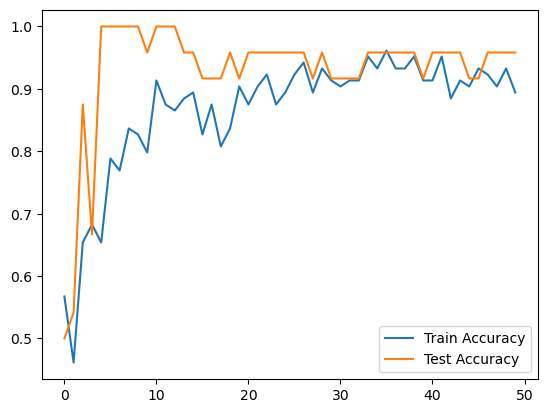

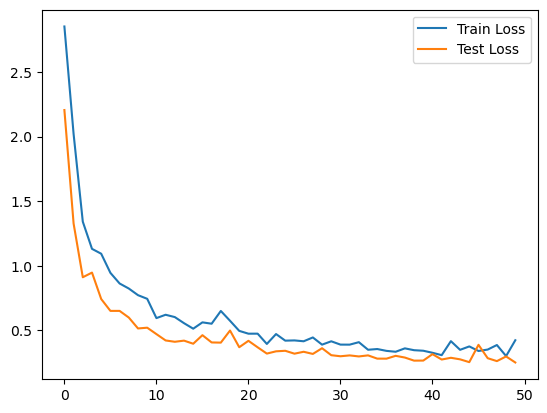

In [30]:
# Plot loss and accuracy curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

In [31]:

# Predictions and Classification Report
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes

# Classification Report
target_names = ['Class 30', 'Class 31']
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

1/1 [==============================] - 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

    Class 30       0.54      0.58      0.56        12
    Class 31       0.55      0.50      0.52        12

    accuracy                           0.54        24
   macro avg       0.54      0.54      0.54        24
weighted avg       0.54      0.54      0.54        24



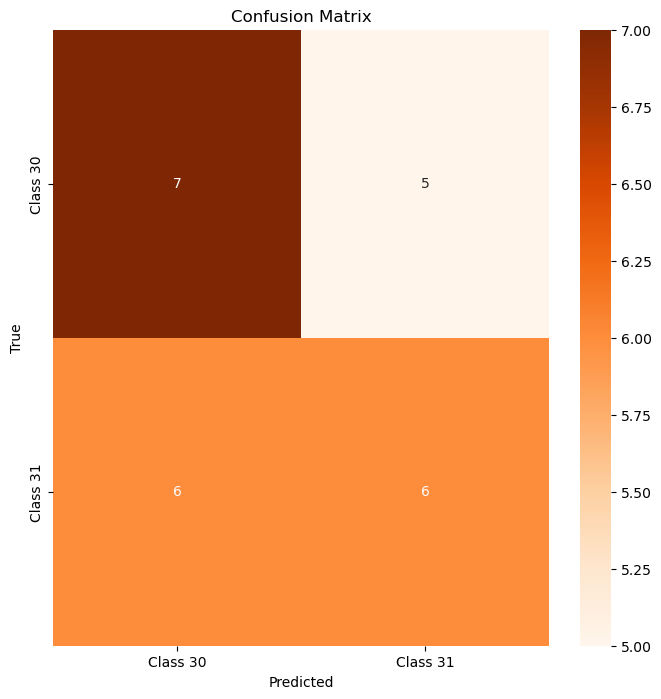

In [36]:
# Plot confusion matrix with numerical values in each cell
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Oranges", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
